In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

# Понижение размерности. Поиск аномалий

## Разведочный анализ и предобработка данных

Мы изучили частоты использования кодонов в геномной кодирующей ДНК большой выборки разнообразных организмов из разных таксонов, сведенных в таблицу в базе данных CUTG, где мы далее вручную отобрали и гармонизировали эти существующие записи, переклассифицировав класс бактерий CUTG (bct) на археи (arc), плазмиды (plm) и собственно бактерии (сохранив исходную метку `bct'). Переклассификация в исходном домене `bct' была упрощена путем извлечения из файлов `qbxxx.spsum.txt' (где xxx = bct (бактерии), inv (беспозвоночные), mam (млекопитающие), pln (растения), pri (приматы), rod (грызуны), vrt (позвоночные)) различных названий родов записей и проведения классификации по родам. Было 514 различных названий родов. Различные категории родов были проверены и перемаркированы как `arc', где это было уместно. В записях эубактерий было сделано различие между собственно бактериальными геномами (с сохранением исходной метки `bct') и бактериальными плазмидами (теперь обозначенными `plm').

После этих этапов предварительной обработки окончательный файл набора данных содержит все записи баз данных CUTG qbxxx.spsum.txt в одном текстовом файле. Как подробно описано выше, записи qbbct.spsum.txt были разделены на `bct' (то есть эубактерии), `plm' (плазмиды) и `arc' (археи), различие, которое изначально не проводилось в базе данных CUTG.

'Kingdom' — это трехбуквенный код, соответствующий «xxx» в названии базы данных CUTG: «arc» (археи), «bct» (бактерии), «phg» (бактериофаги), «plm» (плазмиды), «pln» (растения), «inv» (беспозвоночные), «vrt» (позвоночные), «mam» (млекопитающие), «rod» (грызуны), «pri» (приматы) и «vrl» (вирусы) записи последовательностей. Обратите внимание, что база данных CUTG не содержит «arc» и «plm» (они были вручную отобраны нами).

'DNAtype' обозначается как целое число для геномного состава вида: 0-геномный, 1-митохондриальный, 2-хлоропластный, 3-цианелльный, 4-пластидный, 5-нуклеоморфный, 6-вторичный_эндосимбионтный, 7-хромопластный, 8-лейкопластный, 9-NA, 10-пропластидный, 11-апикопластный и 12-кинетопластный.

Идентификатор вида ('SpeciesID') представляет собой целое число, которое однозначно указывает на записи организма. Это идентификатор доступа для каждого отдельного вида в исходной базе данных CUTG, за которым следует первый элемент, указанный в каждом геноме.

Количество кодонов (`Ncodons') представляет собой алгебраическую сумму чисел, указанных для различных кодонов в записи CUTG. Частоты кодонов нормализуются по отношению к общему количеству кодонов, поэтому количество вхождений, деленное на «Ncodons», представляет собой частоты кодонов, указанные в файле данных.

Название вида («SpeciesName») представлено в строках, очищенных от «запятой» (которая теперь заменена на «пробел»). Это описательная метка названия вида для интерпретации данных.

Наконец, частоты кодонов («codon»), включая «UUU», «UUA», «UUG», «CUU» и т. д., записываются как числа с плавающей точкой (с десятичными знаками в 5 цифр).

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [24]:
codon_usage = pd.read_csv('/content/drive/My Drive/Colab Notebooks/codon_usage.csv', low_memory=False)

In [25]:
codon_usage.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [26]:
codon_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13028 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13028 non-null  object 
 1   DNAtype      13028 non-null  int64  
 2   SpeciesID    13028 non-null  int64  
 3   Ncodons      13028 non-null  int64  
 4   SpeciesName  13028 non-null  object 
 5   UUU          13028 non-null  object 
 6   UUC          13028 non-null  object 
 7   UUA          13028 non-null  float64
 8   UUG          13028 non-null  float64
 9   CUU          13028 non-null  float64
 10  CUC          13028 non-null  float64
 11  CUA          13028 non-null  float64
 12  CUG          13028 non-null  float64
 13  AUU          13028 non-null  float64
 14  AUC          13028 non-null  float64
 15  AUA          13028 non-null  float64
 16  AUG          13028 non-null  float64
 17  GUU          13028 non-null  float64
 18  GUC          13028 non-null  float64
 19  GUA 

In [49]:
codon_usage.drop(codon_usage.loc[codon_usage.UUU =='non-B hepatitis virus'].index.values[0], axis=0, inplace=True)
codon_usage.drop(codon_usage.loc[codon_usage.UUU =='12;I'].index.values[0], axis=0, inplace=True)

codon_usage.UUU = codon_usage.UUU.astype(float)
codon_usage.UUC = codon_usage.UUC.astype(float)

In [55]:
codon_usage.describe()

,DNAtype,SpeciesID,Ncodons,UUU,UUC,UUA,UUG,CUU,CUC,CUA,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
count,13026.000000,13026.000000,1.302600e+04,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,...,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000
mean,0.367265,130443.036926,7.961776e+04,0.024818,0.023440,0.020637,0.014104,0.017821,0.018287,0.019045,...,0.005453,0.009930,0.006423,0.024181,0.021164,0.028291,0.021683,0.001640,0.000590,0.006179
std,0.688764,124777.067741,7.197556e+05,0.017628,0.011598,0.020710,0.009280,0.010587,0.014573,0.024252,...,0.006601,0.008574,0.006388,0.013826,0.013039,0.014343,0.015019,0.001785,0.000882,0.010345
min,0.000000,7.000000,1.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28851.250000,1.602000e+03,0.013910,0.015380,0.005610,0.007103,0.010890,0.007830,0.005302,...,0.001220,0.001690,0.001170,0.012390,0.011860,0.017360,0.009710,0.000560,0.000000,0.000410
50%,0.000000,81971.500000,2.929000e+03,0.021750,0.021905,0.015260,0.013360,0.016130,0.014560,0.009680,...,0.003530,0.009270,0.004545,0.025425,0.019070,0.026085,0.020540,0.001380,0.000420,0.001130
75%,1.000000,222890.500000,9.120000e+03,0.031308,0.029210,0.029495,0.019808,0.022730,0.025110,0.017255,...,0.007150,0.015928,0.010250,0.034190,0.027690,0.036800,0.031128,0.002370,0.000830,0.002890
max,12.000000,465364.000000,4.066258e+07,0.217300,0.091690,0.151330,0.101190,0.089780,0.100350,0.163920,...,0.055540,0.098830,0.058430,0.185660,0.113840,0.144890,0.158550,0.045200,0.025610,0.106700


In [56]:
codon_usage.describe(include=['O'])

,Kingdom,SpeciesName
count,13026,13026
unique,11,13014
top,bct,Escherichia coli O157
freq,2919,4


In [57]:
def obj_in_int(df):
  for column in df:
    if df[column].dtype == 'O':
      df.loc[:, 'Ind_' + column] = pd.factorize(df[column])[0]

In [58]:
obj_in_int(codon_usage)

In [59]:
codon_usage.head(5)

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA,Ind_Kingdom,Ind_SpeciesName
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000,0,0
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000,0,1
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144,0,2
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000,0,3
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131,0,4


## Понижение размерности (Dimensionality Reduction)

In [60]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble

In [67]:
'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier
'''

# Ind_SpeciesName нужно убрать, все его значения уникальны и SpeciesName это полное название объекта
feature_dataset = codon_usage.drop(['Kingdom', 'SpeciesID', 'SpeciesName', 'Ind_Kingdom', 'Ind_SpeciesName'], axis=1)
X = feature_dataset.values
y = codon_usage.Ind_Kingdom.values

from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
y = lab_enc.fit_transform(y)

feature_names = feature_dataset.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

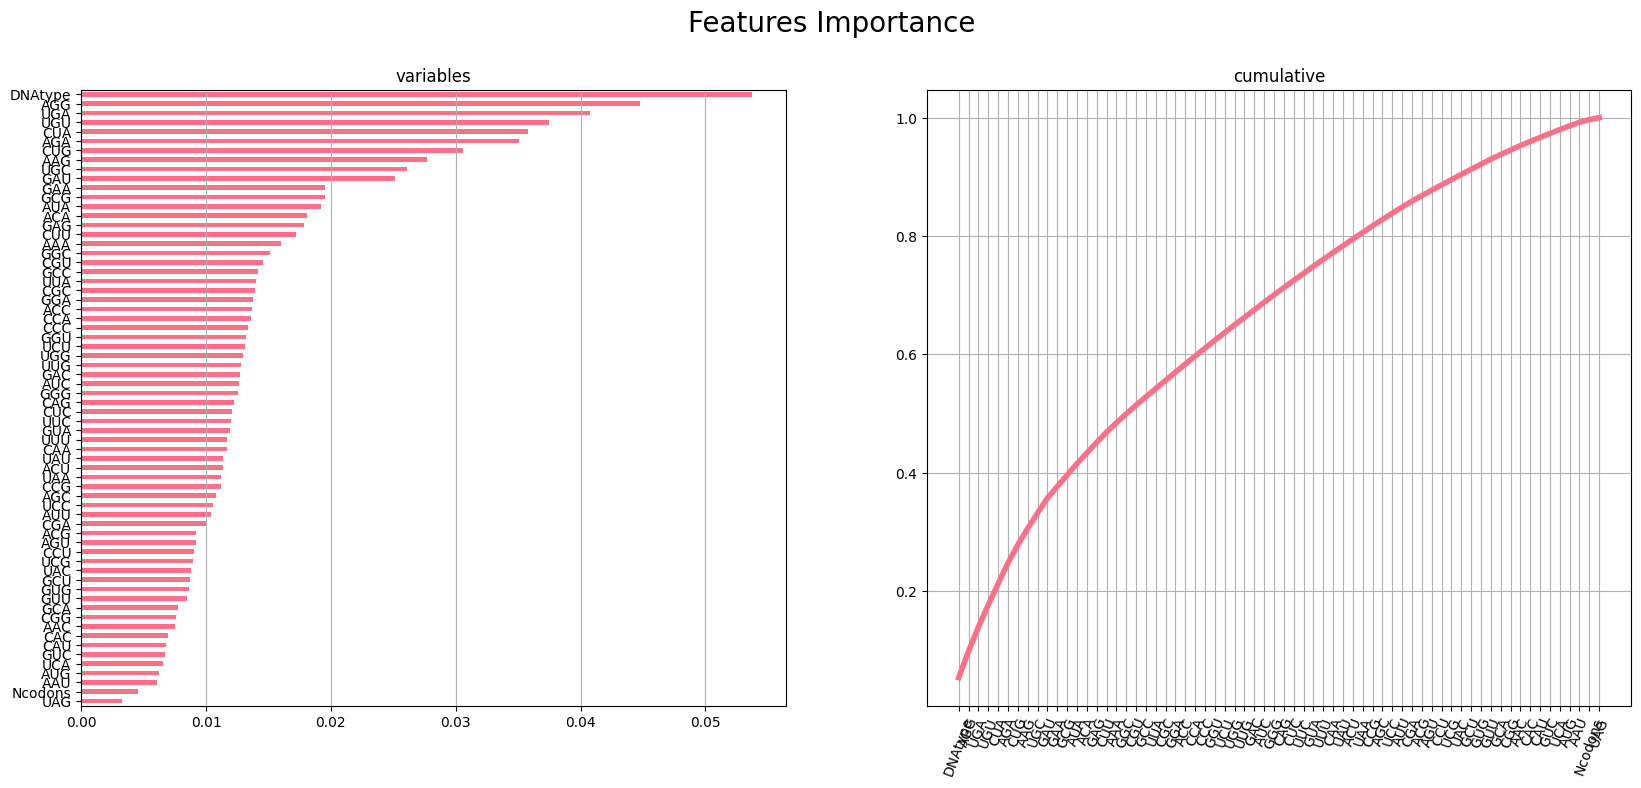

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(20,8),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.
'''
Отрисовываем
'''
plt.show()

In [189]:
'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier
'''
feature_dataset = codon_usage.drop(['Kingdom', 'SpeciesID', 'SpeciesName', 'DNAtype', 'Ind_SpeciesName'], axis=1)
X = feature_dataset.values
y = codon_usage.DNAtype.values

from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
y = lab_enc.fit_transform(y)

feature_names = feature_dataset.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

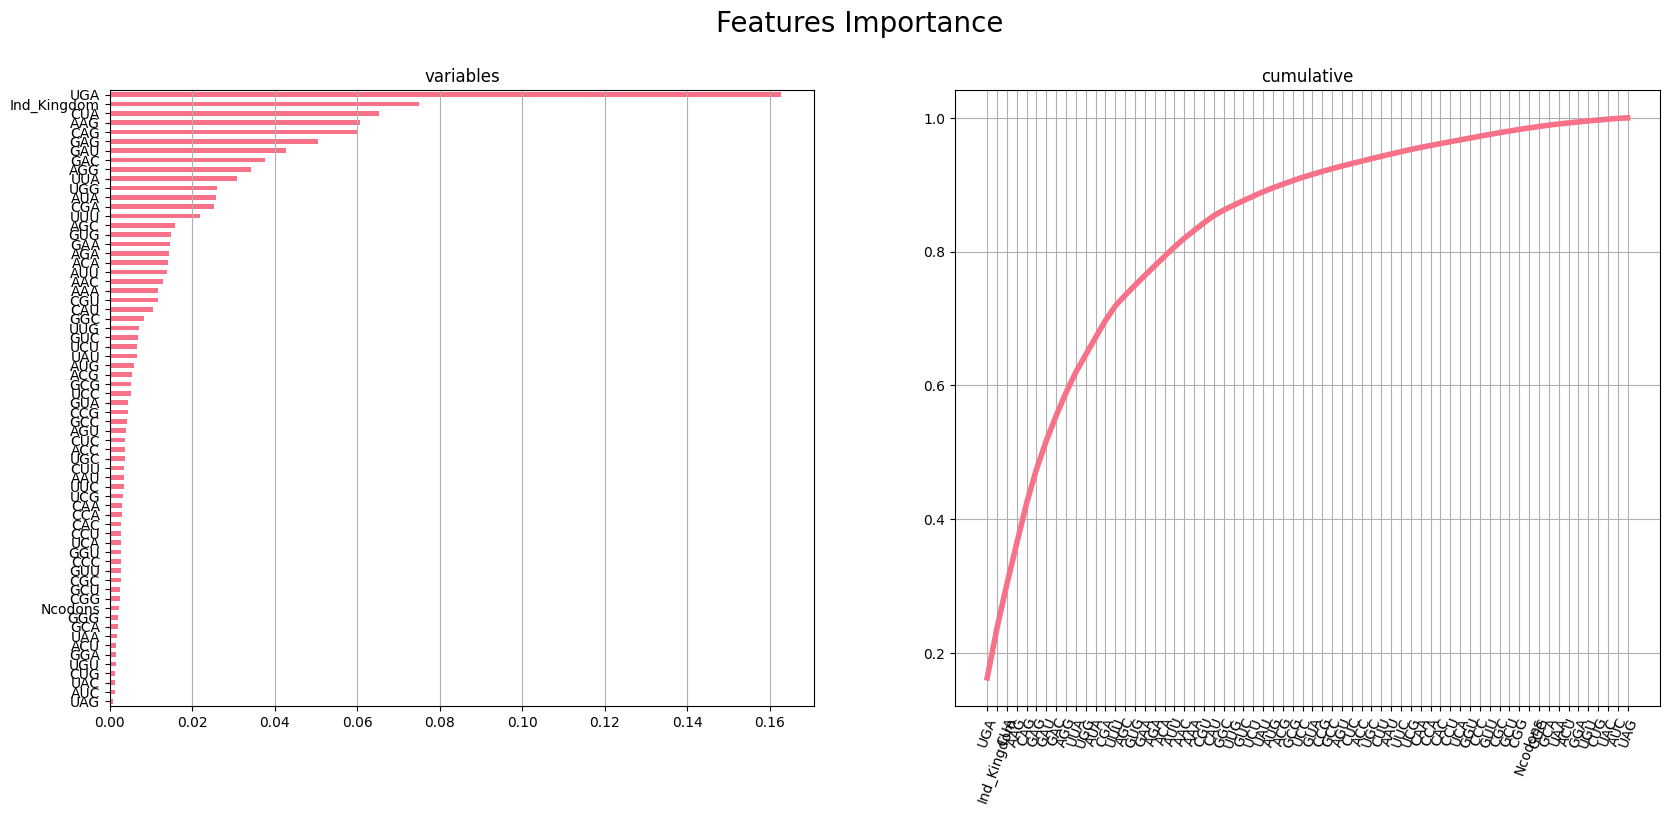

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(20,8),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.
'''
Отрисовываем
'''
plt.show()

### Метод главных компонентов (Principal Component Analysis, PCA)

In [71]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

In [89]:
cols_for_clusters = feature_names
vals = codon_usage.DNAtype.unique()

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

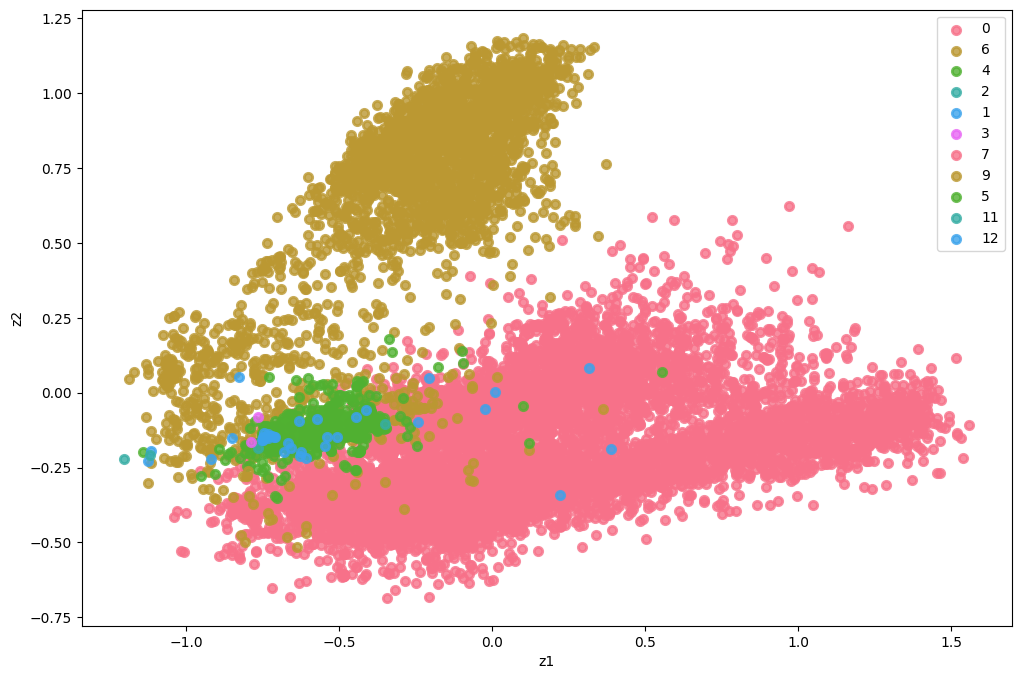

In [90]:
pca = PCA(n_components=2)
X_new = pca.fit(X).transform(X)


plt.figure(figsize=(12,8))
lw = 2

for i, target_name in zip(range(len(vals)), cols_for_clusters):
    plt.scatter(
        X_new[y == i, 0], X_new[y == i, 1], alpha=0.8, lw=lw, label=vals[i]
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

In [91]:
pca.explained_variance_ratio_

array([0.31534575, 0.23566178])

### Независисый анализ компонентов (Independent Component Analysis, ICA)

In [92]:
from sklearn.decomposition import FastICA

fast_ica = FastICA(n_components=2)
X_new = fast_ica.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


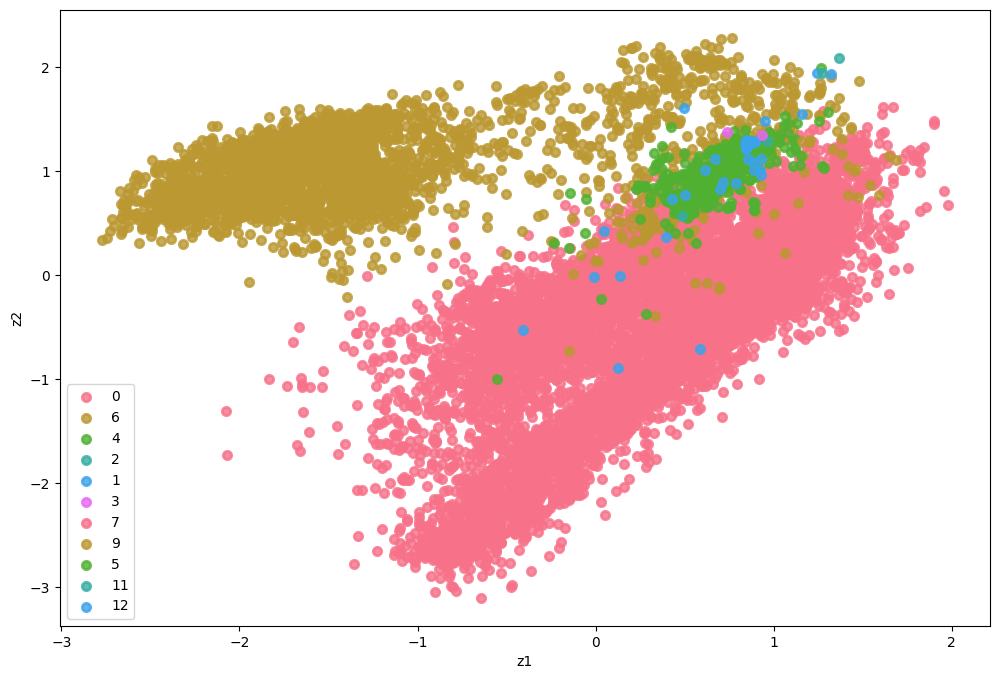

In [93]:
plt.figure(figsize=(12,8))
lw = 2

for i, target_name in zip(range(len(vals)), cols_for_clusters):
    plt.scatter(
        X_new[y == i, 0], X_new[y == i, 1], alpha=0.8, lw=lw, label=vals[i]
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

In [191]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_new = rbf_pca.fit_transform(X)

In [194]:
# Вывод результатов
print('Initial Shape of X: ', X.shape)
print('New Shape of X: ', X_new.shape)
#print('Embedding vectors: ', tsne.embedding_)

Initial Shape of X:  (13026, 66)
New Shape of X:  (13026, 2)


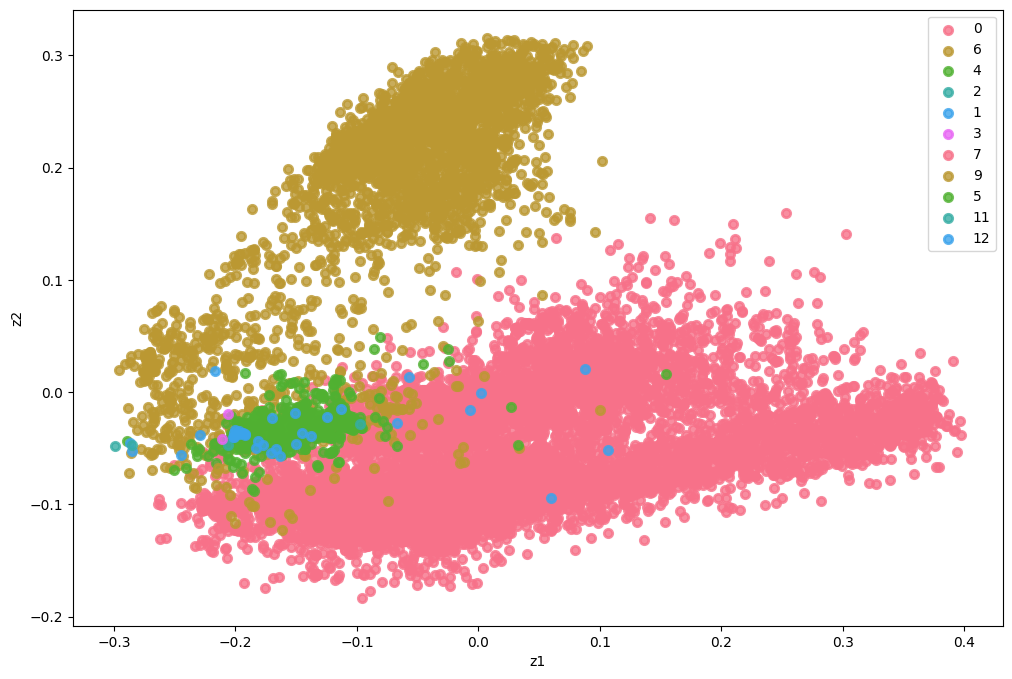

In [95]:
plt.figure(figsize=(12,8))

lw = 2

for i, target_name in zip(range(len(vals)), cols_for_clusters):
    plt.scatter(
        X_new[y == i, 0], X_new[y == i, 1], alpha=0.8, lw=lw, label=vals[i]
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

In [96]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_new = tsne.fit_transform(X)

In [97]:
# Вывод результатов
print('Initial Shape of X: ', X.shape)
print('New Shape of X: ', X_new.shape)
print('Kullback-Leibler divergence after optimization: ', tsne.kl_divergence_)
print('No. of iterations: ', tsne.n_iter_)
#print('Embedding vectors: ', tsne.embedding_)

Initial Shape of X:  (13026, 66)
New Shape of X:  (13026, 2)
Kullback-Leibler divergence after optimization:  1.2633706331253052
No. of iterations:  999


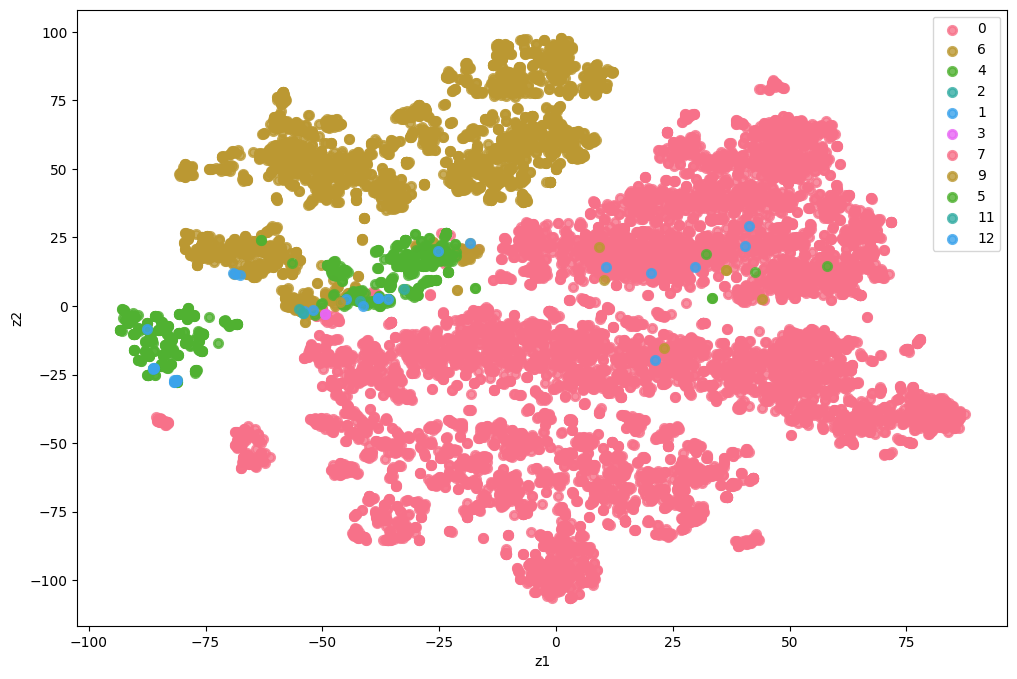

In [98]:
plt.figure(figsize=(12,8))

lw = 2

for i, target_name in zip(range(len(vals)), cols_for_clusters):
    plt.scatter(
        X_new[y == i, 0], X_new[y == i, 1], alpha=0.8, lw=lw, label=vals[i]
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

## Поиск выбросов. DBSCAN

In [99]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score

In [100]:
dbscan_cluster1 = DBSCAN(eps = 0.28, min_samples = 3)
X_new = dbscan_cluster1.fit(X)

In [101]:
# Number of Clusters
labels=dbscan_cluster1.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster1.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(y, labels))

Estimated no. of clusters: 405
Estimated no. of noise points: 5820
v_measure = 0.22735997929300414


### DBSCAN для кластеризации

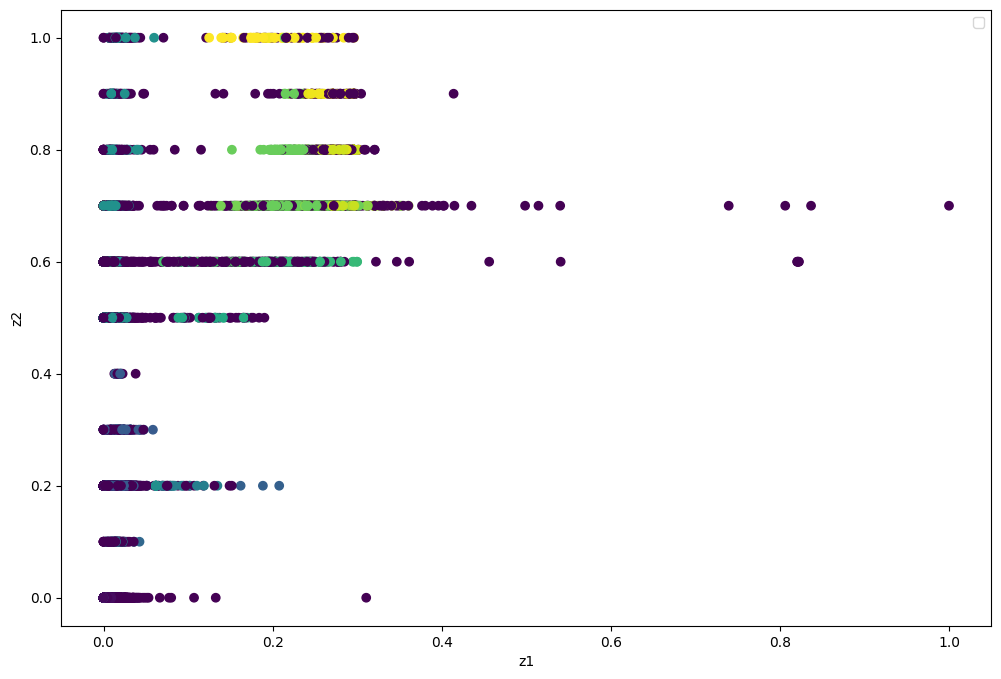

In [134]:
plt.figure(figsize=(12,8))

lw = 2

best_features = dtf_importances['IMPORTANCE'][:4].index.values

X = scaler.fit_transform(feature_dataset[best_features].values)

plt.scatter(
        X[:, 0], X[:, 1], c=dbscan_cluster1.labels_
    )

plt.legend(loc="best", shadow=False, scatterpoints=2)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

In [160]:
from sklearn.neighbors import NearestNeighbors

best_features = dtf_importances['IMPORTANCE'][:7].index.values
X = scaler.fit_transform(feature_dataset[best_features])

min_samples = 3

knn = NearestNeighbors(n_neighbors = min_samples, metric = 'l2')
knn.fit(X)

dists, inds = knn.kneighbors(X)
dists_ar = dists[:, 1:min_samples].mean(axis=1)
dists_ar.sort()

In [161]:
import sklearn
#возможные метрики расстояния
sklearn.metrics.pairwise.distance_metrics()

{'cityblock': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_distances(X, Y=None)>,
 'euclidean': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'haversine': <function sklearn.metrics.pairwise.haversine_distances(X, Y=None)>,
 'l2': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'l1': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'manhattan': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'precomputed': None,
 'nan_euclidean': <function sklearn.metrics.pairwise.nan_euclidean_distances(X, Y=None, *, squared=False, missing_values=nan, copy=True)>}

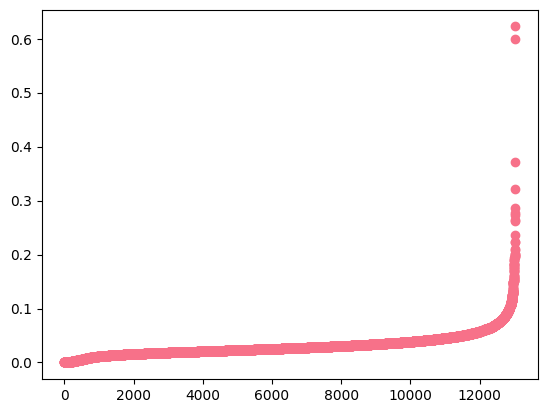

In [162]:
plt.scatter(x = range(len(dists_ar)), y=dists_ar)
plt.show()

### DBSCAN для определения выбросов

In [163]:
dbscan = DBSCAN(eps = 0.5, min_samples = min_samples)
print(dbscan)

DBSCAN(min_samples=3)


In [164]:
pred = dbscan.fit_predict(X)

In [165]:
# Number of Clusters
labels=dbscan.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(y, labels))

Estimated no. of clusters: 1
Estimated no. of noise points: 2
v_measure = 0.00013483081420145851


In [169]:
# у анномалий - класс -1, ищем все номера строк с таким классом, потом отбираем эти строки из начального набора данных

anom_index = [i for i in range(len(pred)) if pred[i] == -1]
values = X[anom_index]

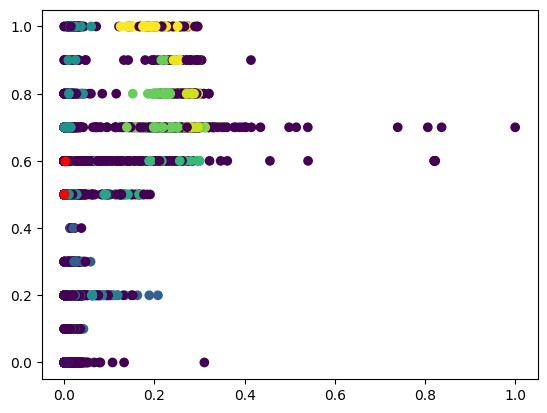

In [188]:
plt.scatter( X[:, 0], X[:, 1],c=dbscan_cluster1.labels_)
plt.scatter(values[:, 0], values[:, 1], color='r')
plt.show()